<a href="https://colab.research.google.com/github/wilmi94/MasterThesis/blob/main/MT_Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Master Thesis -1st Prototype
key aspects of this prototype:

- try to download first images using SunPy modules
- building a fist data-pipeline
  - (automatic) data/image download from JSOC
  - preprocessing of images
  - labeling
- building a simple ML model
- running a simple ConvNet
- testing the model


## Setup

In [3]:
# Standard Libaries
import os
import zipfile
import urllib.request
import cv2
import re
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# SunPy stuff:
import drms
from astropy.io import fits
import drms

# Tensorflow stuff:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

## Getting the Data
To access the JSOC DRMS from Python, we first need to import the drms module and create an instance of the Client class:

In [2]:
pip install drms

Create DRMS client, uses the JSOC baseurl by default, set debug=True to see the DRMS query URLs

In [4]:
client = drms.Client()

All available data series can be now retrieved by calling the drms.client.Client.series() method. HMI series names start with "hmi.", AIA series names with "aia." and the names of MDI series with "mdi.".

The first (optional) parameter of this method takes a regular expression that allows you to filter the result. If you, for example, want to obtain a list of HMI series, with a name that start with the string "m_", you can write:

In [7]:
client.series(r'hmi\.m'); # show available data (remove ;)

### Downloading HMI data
download HMI synoptic data from JSOC and make a plot.

Construct the DRMS query string: “Series[Carrington rotation]”

In [8]:
#qstr = 'hmi.synoptic_mr_720s[2251]'
qstr = 'hmi.mrdailysynframe_720s_nrt[$]'

# Send request to the DRMS server
print('Querying keyword data...\n -> {qstr}')
segname = 'data' #'synopMr'
results, filenames = client.query(qstr, key=drms.const.all, seg=segname)
print(f' -> {len(results)} lines retrieved.')

# Use only the first line of the query result
results = results.iloc[0]
print('Retrived Data: \n', results)

fname = f'http://jsoc.stanford.edu{filenames[segname][0]}'

# Read the data segment
# Note: HTTP downloads get cached in ~/.astropy/cache/downloads
print(f'Reading data from {fname}...')
a = fits.getdata(fname)
ny, nx = a.shape

Querying keyword data...
 -> {qstr}
 -> 1 lines retrieved.
Retrived Data: 
 DATE                                 2022-02-15T14:02:10Z
TELESCOP                                          SDO/HMI
INSTRUME                                     HMI_COMBINED
WAVELNTH                                           6173.0
BUNIT                                             Mx/cm^2
                                ...                      
DATARMS                                         37.038524
DATASKEW                                        -1.753569
DATAKURT                                       591.520511
CALVER64                                        268706066
CODEVER     :127:JSOC Production:/home/jsocprod:/bin/tcsh
Name: 0, Length: 86, dtype: object
Reading data from http://jsoc.stanford.edu/SUM93/D1488232150/S00000/data.fits...


### Plot image

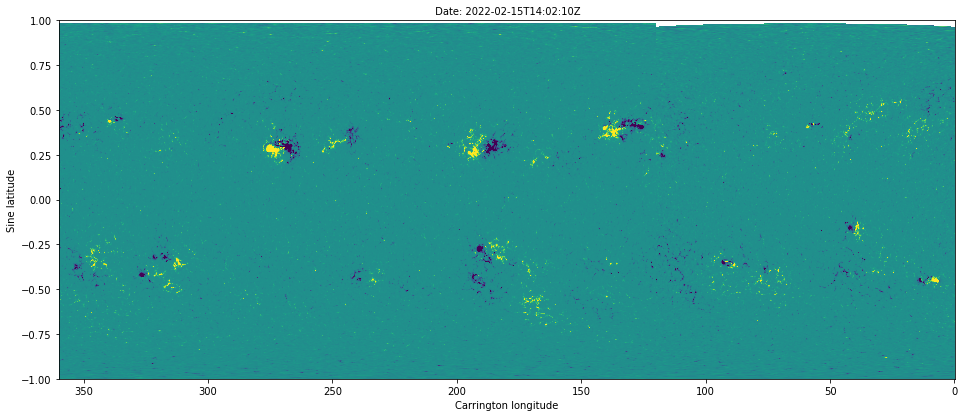

In [9]:
# Convert pixel to world coordinates using WCS keywords
xmin = (1 - results.CRPIX1) * results.CDELT1 + results.CRVAL1
xmax = (nx - results.CRPIX1) * results.CDELT1 + results.CRVAL1
ymin = (1 - results.CRPIX2) * results.CDELT2 + results.CRVAL2
ymax = (ny - results.CRPIX2) * results.CDELT2 + results.CRVAL2

# Convert to Carrington longitude
xmin = results.LON_LAST - xmin
xmax = results.LON_LAST - xmax

# Compute the plot extent used with imshow
extent = (
    xmin - abs(results.CDELT1) / 2,
    xmax + abs(results.CDELT1) / 2,
    ymin - abs(results.CDELT2) / 2,
    ymax + abs(results.CDELT2) / 2,
)

# Aspect ratio for imshow in respect to the extent computed above
aspect = abs((xmax - xmin) / nx * ny / (ymax - ymin))

# Create plot
fig, ax = plt.subplots(1, 1, figsize=(13.5, 6))
#ax.set_title(f'{qstr}, Time: {results.T_START} ... {results.T_STOP}', fontsize='medium')
ax.set_title(f' Date: {results.DATE}', fontsize='medium')
ax.imshow(
    a, vmin=-300, vmax=300, origin='lower', interpolation='nearest', extent=extent, aspect=aspect)#, cmap='gray') # for grayscale include , cmap='gray'

ax.invert_xaxis()
ax.set_xlabel('Carrington longitude')
ax.set_ylabel('Sine latitude')
fig.tight_layout()

In [12]:
print(str(a.size))

5184000


## Data Pipeline

### Download data over a larger time interval
Now that is was shown that it is possible to download at least one HMI image and conduct a simple preprocessing

# A simple ConvNet Model
First, the images have to be imported into the Python session. The first step is to process the images into a format that 
1. makes the data readable to the model, and 
2. provides more training material for the model to learn. 

For example, the train_processor variable scales the data so that it can be a feature (input) for the model, but also takes each images and **augments** it so that the model can learn from **multiple variations of the same picture**. 

It flips it horizontally, rotates it, and shifts it, and more to make sure the model learns from the shape of the bit rather than the orientation or size.

In [ ]:
# Data processing
train_processor = ImageDataGenerator(rescale = 1./255, \
    horizontal_flip = True, zoom_range = 0.2,          \
    rotation_range = 10, shear_range = 0.2,            \
    height_shift_range = 0.1, width_shift_range = 0.1)
test_processor = ImageDataGenerator(rescale = 1./255)

# Load data
train = train_processor.flow_from_directory('train',   \
    target_size = (256, 256), batch_size = 32,         \
    class_mode = 'categorical', shuffle = True)

test = test_processor.flow_from_directory('test',      \
    target_size = (256 ,256), batch_size = 32,         \
    class_mode = 'categorical', shuffle = False)

## Model building
Next step is to build the CNN model with options for building the model. This includes the number of convolutional layers, fully connected dense layers, the number of nodes in each layer, and the number of training epochs. For more information on these parameters and Convolutional Neural Networks in general, see Computer Vision with Deep Learning. Change these parameters and analyze the performance of the model.

In [13]:
# choose model parameters
num_conv_layers = 2
num_dense_layers = 1
layer_size = 64
num_training_epochs = 20

In [14]:
# Initiate model variable
model = Sequential()

# begin adding properties to model variable
# e.g. add a convolutional layer
model.add(Conv2D(layer_size, (3, 3), input_shape=(256,256, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# add additional convolutional layers based on num_conv_layers
for _ in range(num_conv_layers-1):
    model.add(Conv2D(layer_size, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

# reduce dimensionality
model.add(Flatten())

# add fully connected "dense" layers if specified
for _ in range(num_dense_layers):
    model.add(Dense(layer_size))
    model.add(Activation('relu'))

# add output layer
model.add(Dense(3))
model.add(Activation('softmax'))

# compile the sequential model with all added properties
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'],
                )

# use the data already loaded previously to train/tune the model
model.fit(train,
            epochs=num_training_epochs,
            validation_data = test)

# save the trained model
model.save(f'bits.h5')

NameError: ignored

## Model Testing
The model is trained and saved as an h5 file. The last line of the printed output contains the accuracy for both the training and testing data.

The val_accuracy is the accuracy on the test images that are not included in the training. Hyperparameter optimization can be used to improve the accuracy by adjusting the CNN architecture, training selections, or other parameters. The function make_prediction takes the file path to a drill bit photo as an input and produces a classification result.

In [ ]:
btype = ['PDC', 'Roller Cone', 'Spoon'] # possible output values
def make_prediction(image_fp):
    im = cv2.imread(image_fp) # load image
    plt.imshow(im)
    img = image.load_img(image_fp, target_size = (256,256))
    img = image.img_to_array(img)

    image_array = img / 255. # scale the image
    img_batch = np.expand_dims(image_array, axis = 0)
    
    predicted_value = btype[model.predict(img_batch).argmax()]
    true_value = re.search(r'(PDC)|(Roller Cone)|(Spoon)', image_fp)[0]
    
    out = f"""Predicted Bit Type: {predicted_value}
    True Bit Type: {true_value}
    Correct?: {predicted_value == true_value}"""
    
    return out

In [ ]:
# randomly select type (1-3) and image number (1-5)
i = random.randint(0,2); j = random.randint(1,5)
b = btype[i]; im = b.replace(' ','_').lower() + '_' + str(j) + '.jpg'
test_image_filepath = r'./test/'+b+'/'+im
print(make_prediction(test_image_filepath))